In [1]:
from __future__ import print_function

import rospy
from geometry_msgs.msg import Twist
from rospy.timer import sleep
from geometry_msgs.msg import PoseStamped
from nav_msgs.msg import Odometry
from std_msgs.msg import Int16
from PIL import Image
import numpy as np
import cv2 
from nav_msgs.msg import Path
import time
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt as bwdist
from IPython.display import HTML
import matplotlib.animation as animation

In [2]:
im = Image.open("/home/scifiswapnil/Desktop/jackal_ws/src/jackal_sim/map/stage_one.pgm")
map_grid = np.asarray(im)
map_grid = np.where(map_grid==205, 0, map_grid)
map_grid = np.where(map_grid>=250, 255, map_grid)
ret,thresh1 = cv2.threshold(map_grid,127,255,cv2.THRESH_BINARY)
map_grid = np.invert(thresh1)
# kernel = np.ones((120,120),np.uint8)
# map_grid = cv2.dilate(map_grid,kernel,iterations = 1)
map_grid = np.invert(map_grid)

map_x = 4992 # in pixels
map_y = 4992 # in pixels
map_res = 0.01 # in meters

cv2.imshow("map_grid", cv2.resize(map_grid, (600,600)))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [3]:
def meters2grid(pose_m):
    if np.isscalar(pose_m):
        pose_on_grid = int( pose_m/ map_res + (map_x/2) )
    else:
        pose_on_grid = np.array( np.array([(map_x/2),(map_x/2)]) + np.array(pose_m)/ map_res, dtype=int)
        pose_on_grid[1] = -pose_on_grid[1] + map_x
    return pose_on_grid

def grid2meters(pose_grid):
    if np.isscalar(pose_grid):
        pose_meters = (pose_grid* map_res + -24.96)
    else:
        pose_meters = ( np.array(pose_grid)* map_res + np.array([-24.96, -24.96]) )
        pose_meters[1] = -pose_meters[1]
    return pose_meters

In [4]:
class formation_controller:
    def __init__(self,name,robots):
        self.formation_name = name
        self.robots_in_formation = robots
        self.formation_centroid = None
        self.path_point = 0
        self.boundingbox = 100
        self.path = None
        self.map = None
        rospy.Subscriber("/path", Path, self.path_callback)
        
    def init_position(self):
        self.path_point = 0
    
    def next_position(self,by=1):
        self.path_point = self.path_point + by 
        
    def previous_position(self,by=1):
        self.path_point = self.path_point - by
    
    def draw_local_region(self):
        x = self.path[0,self.path_point]
        y = self.path[1,self.path_point]
        x,y = meters2grid((x,y))
        plt.imshow(self.map)
        ax = plt.gca()
        rect = Rectangle((x-100,y-100),200,200,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        plt.plot(x, y, "xr")
        plt.plot(x - 100, y - 100, "xg")
        plt.plot(x + 100, y + 100, "xb")
        return plt
    
    def get_local_region(self):
        x = self.path[0,self.path_point]
        y = self.path[1,self.path_point]
        x,y = meters2grid((x,y))
        roi = self.map[y-100:y+100,x-100:x+100]
        return roi
    
    def get_formation_centroid(self):
        x = self.path[0,self.path_point]
        y = self.path[1,self.path_point]
        x,y = meters2grid((x,y))
        return np.array([x,y])
        
    def get_map(self):
        return self.map
    
    def get_path(self):
        return self.path
        
    def set_complete_map(self,data):
        print("formation : got the map")
        self.map = data    
    
    def set_formation_region(self):
        print("formation : setting robot regions")
        for i in range(len(self.robots_in_formation)):
            self.robots_in_formation[i].set_region(self.get_local_region())
    
    def compute_formation_forces(self,goals):
        print("formation : robot forces")
        if (len(self.robots_in_formation) != len(goals)):
            print("problem")
            return
        for i in range(len(self.robots_in_formation)):
            self.robots_in_formation[i].compute_forces(goal = goals[i])
            self.robots_in_formation[i].visualize_forces()
    
    def formation_gradient_planner(self,goals,its):
        print("formation : robot planner")
        if (len(self.robots_in_formation) != len(goals)):
            print("problem")
            return
        computed_routes = []
        for i in range(len(self.robots_in_formation)):
            computed_routes.append(self.robots_in_formation[i].gradient_planner(start_coords = goals[i],max_its=its))
        return computed_routes
    
    def path_callback(self,data):
        print("got path")
        self.path = data
        x = []
        y = []
        for i in range(len(data.poses)):
            x.append(data.poses[i].pose.position.x)
            y.append(data.poses[i].pose.position.y)
        self.path = np.vstack((np.flip(np.array(x)),np.flip(np.array(y))))

In [5]:
class agv_controller:
    def __init__(self,name):
        self.robot_name = name
        self.cmd_pub = rospy.Publisher(str(self.robot_name)+'/cmd_vel', Twist, queue_size=10)
        rospy.Subscriber(str(self.robot_name)+'/odometry/filtered', Odometry, self.odom_callback)
        self.current_state = None
        self.current_region = None
        self.force = None
        
    def odom_callback(self,data):
        self.current_state = data
    

    def set_region(self, data):
        print(self.robot_name + " : setting region")
        self.current_region = np.invert(data)
        k = np.ones((5,5),np.uint8)
        self.current_region = cv2.dilate(self.current_region,k,iterations = 1)
        
    def compute_forces(self,goal = [100,20], influence_radius = 7,  
                       repulsive_coef = 200, attractive_coef = 1./100):
        print(self.robot_name + " : compute region forces")
        bdist = bwdist(self.current_region==0)
        bdist2 = (bdist/100.) + 1
        repulsive = repulsive_coef*((1./bdist2 - 1./influence_radius)**2)
        repulsive [bdist2 > influence_radius] = 0
        #attractive
        [x, y] = np.meshgrid(np.arange(200), np.arange(200))
        attractive = attractive_coef * ( (x - goal[0])**2 + (y - goal[1])**2 )
        #add up forces
        force = attractive + repulsive
        self.force = force
        return force
    
    def visualize_forces (self):
        print(self.robot_name + " : visualize region forces")
        skip = 5
        [x_m, y_m] = np.meshgrid(np.linspace(0, 200, 200), np.linspace(0, 200, 200))
        [gy, gx] = np.gradient(self.force);
        gx = -gx
        q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]
        plt.figure(figsize=(5,5))
        plt.imshow(self.current_region)
        plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])
        plt.show()
        
    def gradient_planner (self, start_coords, max_its=10):
        print(self.robot_name + " : region gradient planner")
        [gy, gx] = np.gradient(-self.force);
        route = np.array([np.array(start_coords)])
        for i in range(max_its):
            current_point = route[-1,:];
            ix = int( current_point[1] )
            iy = int( current_point[0] )
            vx = gx[ix, iy]
            vy = gy[ix, iy]
            dt = 1 / np.linalg.norm([vx, vy]);
            next_point = current_point + dt*np.array( [vx, vy] );
            route = np.vstack( [route, next_point] );    
        return route
        
    def print_state(self):
        print(self.robot_name + "printing state")
        print(self.current_state)

In [6]:
rospy.init_node("formation_controller")

#init robot
uav1 = agv_controller("")

#init formation 
formation = formation_controller("square",[uav1])
formation.set_complete_map(map_grid)


formation : got the map


formation : setting robot regions
 : setting region
formation : robot forces
 : compute region forces
 : visualize region forces


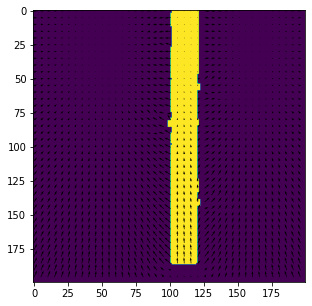

formation : robot planner
 : region gradient planner


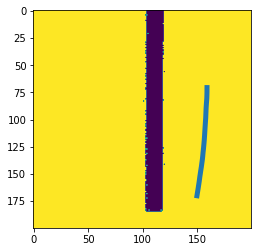

In [9]:
formation.init_position()
formation.next_position(125)
formation.set_formation_region()
formation.compute_formation_forces([[100,20]])
route = formation.formation_gradient_planner([[150,170]],100)
plt.imshow(formation.get_local_region())
plt.plot(route[0][:,0], route[0][:,1], linewidth=5)
plt.show()

In [ ]:
formation.init_position()
formation.next_position(125)
current_region = formation.get_local_region();
current_region = np.invert(current_region)
k = np.ones((5,5),np.uint8)
current_region = cv2.dilate(current_region,k,iterations = 1)
plt.imshow(current_region, cmap=plt.cm.gray)
plt.colorbar()
#255 free
#0 occupied


influence_radius = 7
repulsive_coef = 200
goal = [100,20]
attractive_coef = 1./100

#repulsive
bdist = bwdist(current_region==0)
bdist2 = (bdist/100.) + 1
repulsive = repulsive_coef*((1./bdist2 - 1./influence_radius)**2)
repulsive [bdist2 > influence_radius] = 0
#attractive
[x, y] = np.meshgrid(np.arange(200), np.arange(200))
attractive = attractive_coef * ( (x - goal[0])**2 + (y - goal[1])**2 )
#add up forces
force = attractive + repulsive
# plt.figure(figsize=(10,10))
# plt.imshow(repulsive,cmap=plt.cm.gray)
# plt.colorbar()
# plt.show()

# skip = 5
# [x_m, y_m] = np.meshgrid(np.linspace(0, 200, 200), np.linspace(0, 200, 200))
# [gy, gx] = np.gradient(repulsive);
# gx = -gx
# plt.figure(figsize=(10,10))
# plt.imshow(current_region)
# plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])
# plt.show()

# skip = 5
# [x_m, y_m] = np.meshgrid(np.linspace(0, 200, 200), np.linspace(0, 200, 200))
# [gy, gx] = np.gradient(attractive);
# gx = -gx
# plt.figure(figsize=(10,10))
# plt.imshow(current_region)
# plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])
# plt.show()


skip = 5
[x_m, y_m] = np.meshgrid(np.linspace(0, 200, 200), np.linspace(0, 200, 200))
[gy, gx] = np.gradient(force);
gx = -gx
q_stack = x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]

plt.figure(figsize=(5,5))
plt.imshow(formation.get_local_region())
plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])
plt.show()

In [ ]:
start1 = [40,150]
start2 = [165,150]
start3 = [45,190]
start4 = [165,190]

stop = [100,20]

route1 = gradient_planner(attractive+repulsive, start1,  20)
route2 = gradient_planner(attractive+repulsive, start2,  20)
route3 = gradient_planner(attractive+repulsive, start3,  20)
route4 = gradient_planner(attractive+repulsive, start4,  20)

plt.figure(figsize=(12,12))
#grad planner
plt.imshow(formation.get_local_region())
plt.quiver(x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip]) 
plt.plot(route1[:,0], route1[:,1], linewidth=5)
plt.plot(route2[:,0], route2[:,1], linewidth=5)
plt.plot(route3[:,0], route3[:,1], linewidth=5)
plt.plot(route4[:,0], route4[:,1], linewidth=5)
plt.plot(start1[0],start1[1],'bo', markersize=10, label='start')
plt.plot(start2[0],start2[1],'bo', markersize=10, label='start')
plt.plot(start3[0],start3[1],'bo', markersize=10, label='start')
plt.plot(start4[0],start4[1],'bo', markersize=10, label='start')

plt.plot(route1[-1,0],route1[-1,1],'go', markersize=10, label='start')
plt.plot(route2[-1,0],route2[-1,1],'go', markersize=10, label='start')
plt.plot(route3[-1,0],route3[-1,1],'go', markersize=10, label='start')
plt.plot(route4[-1,0],route4[-1,1],'go', markersize=10, label='start')

plt.legend()
plt.show()

In [ ]:
def combined_potential(obstacles_grid, goal, influence_radius=7, attractive_coef=1./100, repulsive_coef=900, nrows=200, ncols=200):
    """ Repulsive potential """
    d = bwdist(obstacles_grid==0)
    d2 = (d/100.) + 1 # Rescale and transform distances
    d0 = influence_radius
    nu = repulsive_coef
    repulsive = nu*((1./d2 - 1./d0)**2)
    repulsive [d2 > d0] = 0
    """ Attractive potential """
    [x, y] = np.meshgrid(np.arange(ncols), np.arange(nrows))
    xi = -attractive_coef
    attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )
    """ Combine terms """
    f = repulsive + attractive
    return f

def draw_gradient(n, f, nrows=200, ncols=200):
    skip = 5
    [x_m, y_m] = np.meshgrid(np.linspace(0, ncols, ncols), np.linspace(0, nrows, nrows))
    [gy, gx] = np.gradient(-f);
    gx = -gx
#     plt.figure(figsize=(10,10))
#     plt.imshow(n)
    return x_m[::skip, ::skip], y_m[::skip, ::skip], gx[::skip, ::skip], gy[::skip, ::skip])

In [ ]:
formation.init_position()
formation.next_position(135)
plt.figure(figsize=(10,10))
#apf

force = combined_potential(formation.get_local_region(),[20,20], influence_radius=7, 
                           attractive_coef=1./100, repulsive_coef=200, nrows=200, ncols=200)
#grad planner
temp = draw_gradient(current_region,force)
plt.imshow(current_region)
plt.quiver(temp[0],temp[1],temp[2],temp[3])  
plt.show()

In [ ]:
formation.init_position()
formation.next_position(135)


current_region = formation.get_local_region();
current_region = np.invert(current_region)
k = np.ones((5,5),np.uint8)
current_region = cv2.dilate(current_region,k,iterations = 1)

force = combined_potential(current_region,[50,50], influence_radius=7, 
                           attractive_coef=1./50, repulsive_coef=900, nrows=200, ncols=200)
route = gradient_planner(force, [30,40], [170,10], 1000)
plt.figure(figsize=(12,12))
#grad planner
temp = draw_gradient(current_region,force)
plt.imshow(formation.get_local_region())
plt.quiver(temp[0],temp[1],temp[2],temp[3])  
plt.plot(route[:,0], route[:,1], linewidth=5)
plt.plot(30,40,'bo',color='red', markersize=10, label='start')
plt.plot(170, 10,'bo',color='green', markersize=10, label='goal')
plt.legend()

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax1 = fig.add_subplot(1, 1, 1)
uav1 = [101,101]


def navi(uaver,gxx,gxy):
    ix = int( uaver[0] )
    iy = int( uaver[1] )
    vxx = gxx[ix, iy]
    vxy = gxy[ix, iy]
    dtt = 1 / np.linalg.norm([vxx, vxy]);
    dtt = dtt * 4
    return uaver + (dtt*np.array([vxx, vxy]));

formation.init_position()
def animate(i):
    global formation
    ax1.clear()
    formation.next_position(5)
    #apf
    force = combined_potential(formation.get_local_region(),[50,50])
    #grad planner
    temp = draw_gradient(formation.get_local_region(),force)
    ax1.imshow(formation.get_local_region())
    ax1.quiver(temp[0],temp[1],temp[2],temp[3])   
    
ani = animation.FuncAnimation(fig, animate, frames=range(1, 39), interval=700)
HTML(ani.to_html5_video())